<a href="https://colab.research.google.com/github/luisangel181/tesis_ingcivil/blob/main/Variacion_Dimensional_de_Bloques_de_Concreto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tesis: “Adición de poliestireno expandido y fibras de PET recicladas para mejorar las propiedades del bloque de concreto, Cajamarca 2024”

Analisis estadistico ANOVA de los resultados de variacion dimensional de bloques de concreto

Elaborado por: luis Angel Vásquez Chávez

In [1]:
# librerias a importar
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import skew
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar archivo de resultados de resistencia a la compresion - cargar hoja "compresion"
df_variacion = pd.read_excel("/content/drive/MyDrive/RESULTADOS_TESIS CIVIL/Resultados_variacion_dim.xlsx", sheet_name='Vdimenci')

# Visualizar datos
df_variacion.head()

,Dosificación,Bloque 1,Bloque 2,Bloque 3,Bloque 4,Bloque 5,Dimension
0,Patrón,-0.085470,-0.085470,0.042735,0.042735,0.000000,Largo
1,5% PE y 0.5% PET,-0.042735,0.000000,-0.042735,-0.085470,0.085470,Largo
2,10% PE y 0.5% PET,-0.128205,0.085470,0.042735,0.128205,-0.256410,Largo
3,15% PE y 0.5% PET,-0.256410,-0.128205,-0.042735,0.042735,-0.042735,Largo
4,Patrón,-0.297619,-0.446429,-0.297619,-0.297619,-0.446429,Ancho


Pruebas de Normalidad

Se Aplica prueba de Shapiro-Wilk para evaluar si los datos siguen uan distribucion de probabilidad normal. Se emplea en muestras pequeñas (<50 datos)

H0: Los datos siguen una distribución normal.

H1: Los datos no siguen una distribución normal.

Si p > 0.05, se acepta H₀ → Los datos son normales (Aplicar ANOVA clásico).

Si p < 0.05, se rechaza H₀ → Los datos no son normales (Aplicar ANOVA no paramétrico).

In [4]:
# Función para aplicar Shapiro-Wilk y obtener resultados correctamente

def aplicar_shapiro_variacion(data, dimension):
    resultados = []
    dosificaciones = ['Patrón', '5% PE y 0.5% PET', '10% PE y 0.5% PET', '15% PE y 0.5% PET']

    for dosificacion in dosificaciones:
        valores = data[(data['Dimension'] == dimension) & (data['Dosificación'] == dosificacion)].iloc[:, 1:6].values.flatten()
        stat, p = shapiro(valores)
        decision = 'Acepta H₀ (Distribución normal)' if p > 0.05 else 'Rechaza H₀ (No normal)'
        resultados.append([dosificacion, round(stat, 4), round(p, 4), decision])

    # Imprimir tabla
    print(f"\nPrueba de Shapiro-Wilk para la dimensión: {dimension}")
    print("=" * 60)
    print("{:<25} {:<12} {:<12} {:<25}".format("Dosificación", "Estadístico", "Valor p", "Resultado"))
    print("-" * 60)
    for row in resultados:
        print("{:<25} {:<12} {:<12} {:<25}".format(*row))

# Aplicar prueba de Shapiro-Wilk para cada dimensión (Largo, Ancho, Altura)

for dimension in ["Largo", "Ancho", "Altura"]:
    aplicar_shapiro_variacion(df_variacion, dimension)


Prueba de Shapiro-Wilk para la dimensión: Largo
Dosificación              Estadístico  Valor p      Resultado                
------------------------------------------------------------
Patrón                    0.803        0.0857       Acepta H₀ (Distribución normal)
5% PE y 0.5% PET          0.9141       0.4925       Acepta H₀ (Distribución normal)
10% PE y 0.5% PET         0.9034       0.429        Acepta H₀ (Distribución normal)
15% PE y 0.5% PET         0.9418       0.6786       Acepta H₀ (Distribución normal)

Prueba de Shapiro-Wilk para la dimensión: Ancho
Dosificación              Estadístico  Valor p      Resultado                
------------------------------------------------------------
Patrón                    0.684        0.0065       Rechaza H₀ (No normal)   
5% PE y 0.5% PET          0.684        0.0065       Rechaza H₀ (No normal)   
10% PE y 0.5% PET         0.8422       0.171        Acepta H₀ (Distribución normal)
15% PE y 0.5% PET         0.9053       0.4399   

Aplicando la prueba de homogeneidad de Levene

In [5]:
# Aplicar prueba de Levene con media para datos normales y mediana para no normales

# Definir qué dimensiones usarán la media o la mediana según la normalidad
uso_media = ["Largo", "Altura"]  # Cumplen normalidad en todos los grupos
uso_mediana = ["Ancho"]  # No cumple normalidad en algunos grupos

# Aplicar prueba de Levene según la mejor opción para cada dimensión
resultados_levene_mixto = []
dimensiones = df_variacion["Dimension"].unique()

for dimension in dimensiones:
    valores_grupos = [df_variacion[(df_variacion["Dimension"] == dimension) &
                                   (df_variacion["Dosificación"] == dos)].iloc[:, 1:6].values.flatten()
                      for dos in df_variacion["Dosificación"].unique()]

    # Seleccionar si se usa la media o la mediana
    center_method = 'mean' if dimension in uso_media else 'median'

    stat, p = levene(*valores_grupos, center=center_method)
    decision = "Acepta H₀ (Varianzas homogéneas)" if p > 0.05 else "Rechaza H₀ (Varianzas no homogéneas)"
    resultados_levene_mixto.append([dimension, center_method, round(stat, 4), round(p, 4), decision])

# Mostrar los resultados en formato de tabla
print("\nPrueba de Levene con Media o Mediana según Normalidad")
print("=" * 85)
print("{:<15} {:<12} {:<10} {:<10} {:<30}".format("Dimensión", "Método", "Estadístico", "Valor p", "Resultado"))
print("-" * 85)
for row in resultados_levene_mixto:
    print("{:<15} {:<12} {:<10} {:<10} {:<30}".format(*row))


Prueba de Levene con Media o Mediana según Normalidad
Dimensión       Método       Estadístico Valor p    Resultado                     
-------------------------------------------------------------------------------------
Largo           mean         3.2442     0.0498     Rechaza H₀ (Varianzas no homogéneas)
Ancho           median       0.7273     0.5505     Acepta H₀ (Varianzas homogéneas)
Altura          mean         0.7331     0.5473     Acepta H₀ (Varianzas homogéneas)


Aplicando prueba ANOVA

Hipotesis nula (H0): "La adición de poliestireno expandido (PE) y fibras de PET no influye significativamente en la variacion dimensional del bloque de concreto."

Hipotesis alternativa (H1): "La adición de poliestireno expandido (PE) y fibras de PET influye significativamente en la variacion dimensional del bloque de concreto."

In [6]:
# Función para calcular el sesgo de la distribución por cada dosificación en cada dimensión
def calcular_sesgo(data, dimension):
    resultados = []
    dosificaciones = data["Dosificación"].unique()

    for dosificacion in dosificaciones:
        valores = data[(data["Dimension"] == dimension) & (data["Dosificación"] == dosificacion)].iloc[:, 1:6].values.flatten()
        sesgo = skew(valores)  # Calcular el sesgo
        resultados.append([dimension, dosificacion, round(sesgo, 4)])

    return resultados

# Aplicar cálculo de sesgo para cada dimensión
resultados_sesgo = []
for dimension in df_variacion["Dimension"].unique():
    resultados_sesgo.extend(calcular_sesgo(df_variacion, dimension))

# Mostrar los resultados en formato de tabla
print("\nCálculo del Sesgo para cada Dimensión y Dosificación")
print("=" * 65)
print("{:<15} {:<25} {:<10}".format("Dimensión", "Dosificación", "Sesgo"))
print("-" * 65)
for row in resultados_sesgo:
    print("{:<15} {:<25} {:<10}".format(*row))


Cálculo del Sesgo para cada Dimensión y Dosificación
Dimensión       Dosificación              Sesgo     
-----------------------------------------------------------------
Largo           Patrón                    -0.2115   
Largo           5% PE y 0.5% PET          0.75      
Largo           10% PE y 0.5% PET         -0.5322   
Largo           15% PE y 0.5% PET         -0.5433   
Ancho           Patrón                    -0.4082   
Ancho           5% PE y 0.5% PET          -0.4082   
Ancho           10% PE y 0.5% PET         -0.9705   
Ancho           15% PE y 0.5% PET         -0.6289   
Altura          Patrón                    0.2078    
Altura          5% PE y 0.5% PET          -0.0195   
Altura          10% PE y 0.5% PET         -0.645    
Altura          15% PE y 0.5% PET         -0.0      


In [7]:
# Función para aplicar ANOVA clásico o ANOVA de Welch según la homogeneidad
def aplicar_anova(data, dimension, homogeneidad):
    modelo = ols('Variación ~ C(Dosificación)', data=data[data['Dimension'] == dimension]).fit()
    if homogeneidad:
        anova = sm.stats.anova_lm(modelo, typ=2)  # ANOVA clásico
    else:
        anova = sm.stats.anova_lm(modelo, typ=2, robust='hc3')  # ANOVA de Welch
    return anova

# Reestructurar el DataFrame para incluir los valores individuales
df_long_variacion = df_variacion.melt(id_vars=['Dosificación', 'Dimension'],
                                      value_vars=['Bloque 1', 'Bloque 2', 'Bloque 3', 'Bloque 4', 'Bloque 5'],
                                      var_name='Bloque', value_name='Variación')

# Aplicar ANOVA según homogeneidad de varianzas
resultados_anova = {}

# Definir tipo de anova a aplicar
anova_clasico = ["Ancho", "Altura"]
anova_welch = ["Largo"]

resultados_anova["Largo"] = aplicar_anova(df_long_variacion, "Largo", homogeneidad=False)
resultados_anova["Ancho"] = aplicar_anova(df_long_variacion, "Ancho", homogeneidad=True)
resultados_anova["Altura"] = aplicar_anova(df_long_variacion, "Altura", homogeneidad=True)

# Interpretación del resultado
for dimension, anova in resultados_anova.items():
    tipo_anova = 'Clasico' if dimension in anova_clasico else 'de Welch'
    print(f"\n ANOVA {tipo_anova} para la dimensión {dimension}:")
    print("=" * 50)
    print(anova)
    p_valor = anova.iloc[0]["PR(>F)"]
    F_valor = anova.iloc[0]["F"]
    if p_valor < 0.05:
        print("Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la variación dimensional entre las diferentes dosificaciones de bloques de concreto.")
        print(f"Valor p: {p_valor:.6f}")
        print(f"Estadístico F: {F_valor:.4f}")
        print("Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.")
    else:
        print("No se rechaza la hipótesis nula, lo que indica que no hay diferencias significativas en la variación dimensional entre las diferentes dosificaciones.")




 ANOVA de Welch para la dimensión Largo:
                   sum_sq    df         F    PR(>F)
C(Dosificación)  0.014860   3.0  0.418872  0.741917
Residual         0.189203  16.0       NaN       NaN
No se rechaza la hipótesis nula, lo que indica que no hay diferencias significativas en la variación dimensional entre las diferentes dosificaciones.

 ANOVA Clasico para la dimensión Ancho:
                   sum_sq    df          F    PR(>F)
C(Dosificación)  3.941681   3.0  24.217687  0.000003
Residual         0.868056  16.0        NaN       NaN
Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la variación dimensional entre las diferentes dosificaciones de bloques de concreto.
Valor p: 0.000003
Estadístico F: 24.2177
Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.

 ANOVA Clasico para la dimensión Altura:
                   sum_sq    df        F    PR(>F)
C(Dosificación)  0.105194   3.0  0.4067

Analizamos para el ancho

In [8]:
# Filtrar los datos solo para la dimensión "Ancho"
df_ancho = df_variacion[df_variacion["Dimension"] == "Ancho"].melt(id_vars=["Dosificación", "Dimension"],
                                                                   value_vars=["Bloque 1", "Bloque 2", "Bloque 3", "Bloque 4", "Bloque 5"],
                                                                   var_name="Bloque", value_name="Variacion")

# Aplicar la prueba de Tukey para la dimensión Ancho
tukey_ancho = pairwise_tukeyhsd(endog=df_ancho["Variacion"],
                                groups=df_ancho["Dosificación"],
                                alpha=0.05)

# Mostrar resultados
print("Prueba de Tukey para Variación Dimensional en Ancho")
print("=" * 60)
print(tukey_ancho)

Prueba de Tukey para Variación Dimensional en Ancho
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
10% PE y 0.5% PET 15% PE y 0.5% PET   0.8333 0.0002  0.4119 1.2548   True
10% PE y 0.5% PET  5% PE y 0.5% PET   0.5655 0.0071   0.144 0.9869   True
10% PE y 0.5% PET            Patrón   1.2202    0.0  0.7988 1.6417   True
15% PE y 0.5% PET  5% PE y 0.5% PET  -0.2679 0.3011 -0.6893 0.1536  False
15% PE y 0.5% PET            Patrón   0.3869 0.0778 -0.0346 0.8084  False
 5% PE y 0.5% PET            Patrón   0.6548 0.0021  0.2333 1.0762   True
-------------------------------------------------------------------------


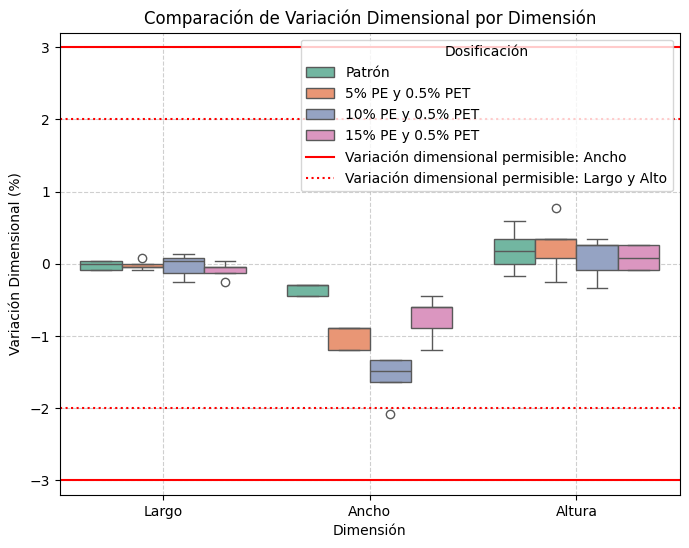

In [17]:
# Crear un gráfico de cajas para comparar la variación dimensional en Largo, Ancho y Altura
plt.figure(figsize=(8, 6))
sns.boxplot(x="Dimension", y="Variacion", hue="Dosificación", data=df_variacion.melt(id_vars=["Dosificación", "Dimension"],
                                                                                     value_vars=["Bloque 1", "Bloque 2", "Bloque 3", "Bloque 4", "Bloque 5"],
                                                                                     var_name="Bloque", value_name="Variacion"),
            palette="Set2")

# Personalizar el gráfico
plt.title("Comparación de Variación Dimensional por Dimensión")
plt.xlabel("Dimensión")
plt.ylabel("Variación Dimensional (%)")
plt.legend(title="Dosificación")
plt.grid(True, linestyle="--", alpha=0.6)

# Ajustar los límites del eje y
plt.ylim(-3.2, 3.2)

# Agregar líneas horizontales
plt.axhline(y=3, color='red', linestyle='-', label="Variación dimensional permisible: Ancho")
plt.axhline(y=-3, color='red', linestyle='-')

plt.axhline(y=2, color='red', linestyle=':', label="Variación dimensional permisible: Largo y Alto")
plt.axhline(y=-2, color='red', linestyle=':')

# Actualizar la leyenda para incluir las líneas horizontales
plt.legend(title="Dosificación")

# Mostrar el gráfico
plt.show()

In [ ]:
# Calcular los valores atípicos para cada dimensión y dosificación por separado
outliers_individuales = []

# Iterar sobre cada dimensión
for dimension in ["Largo", "Ancho", "Altura"]:
    df_actual = df_variacion[df_variacion["Dimension"] == dimension].melt(id_vars=["Dosificación", "Dimension"],
                                                                           value_vars=["Bloque 1", "Bloque 2", "Bloque 3", "Bloque 4", "Bloque 5"],
                                                                           var_name="Bloque", value_name="Variacion")

    # Iterar sobre cada dosificación
    for dosificacion in df_actual["Dosificación"].unique():
        df_dosif = df_actual[df_actual["Dosificación"] == dosificacion]

        # Calcular Q1 (percentil 25) y Q3 (percentil 75) por dosificación
        Q1 = df_dosif["Variacion"].quantile(0.25)
        Q3 = df_dosif["Variacion"].quantile(0.75)
        IQR = Q3 - Q1  # Rango intercuartil

        # Definir límites para valores atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar valores atípicos dentro de cada dosificación
        outliers_dosif = df_dosif[(df_dosif["Variacion"] < limite_inferior) | (df_dosif["Variacion"] > limite_superior)]

        # Guardar los resultados
        for _, row in outliers_dosif.iterrows():
            outliers_individuales.append([dimension, dosificacion, row["Bloque"], row["Variacion"]])

# Convertir los valores atípicos en un DataFrame para visualización
df_outliers_individuales = pd.DataFrame(outliers_individuales, columns=["Dimensión", "Dosificación", "Bloque", "Valor Atípico"])

# Mostrar resultados
print("\n🔹 Valores Atípicos Identificados por Dosificación")
print("=" * 75)
print(df_outliers_individuales)


🔹 Valores Atípicos Identificados por Dosificación
  Dimensión       Dosificación    Bloque  Valor Atípico
0     Largo   5% PE y 0.5% PET  Bloque 5       0.085470
1     Largo  15% PE y 0.5% PET  Bloque 1      -0.256410
2     Ancho  10% PE y 0.5% PET  Bloque 1      -2.083333
3    Altura   5% PE y 0.5% PET  Bloque 1       0.769231
